In [ ]:
from google.colab import drive

drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
# root folder location
root_dir = "/content/drive/MyDrive/Diss/"

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
# location of the dataset created from the feature selection
df = pd.read_csv(root_dir + 'Data/final_dataset.csv')
unique_videos_id = df['video id'].unique()

In [ ]:
df.head()

,Player Distance,P1 f-left,P1 f-right,P1 b-left,P1 b-right,P2 f-left,P2 f-right,P2 b-left,P2 b-right,P1 ball,P2 ball,B f-left,B f-right,B b-left,B b-right,video id,result
0,168.002976,715.629094,768.016276,473.814310,549.749034,654.369926,872.900911,377.524834,690.131147,1715.270241,1685.634895,1039.931248,1314.974144,2014.480578,2169.292972,0,0
1,170.575496,724.572288,772.420222,470.935240,541.671487,650.028461,867.896883,382.899465,690.883492,1676.702717,1633.045009,991.889611,1276.125778,1966.448575,2124.046139,0,0
2,156.003205,715.712931,764.115829,478.037655,547.857646,656.588151,860.511476,386.436282,677.277639,1575.310128,1545.032362,898.761926,1202.000416,1873.365421,2036.303023,0,0
3,146.054784,713.011220,763.584311,478.079491,550.668684,654.006881,851.413531,394.588393,672.963595,1545.007443,1513.492649,871.516494,1177.244664,1846.243754,2008.725964,0,0
4,137.295302,717.864890,769.109875,473.080331,547.727122,657.282283,846.763249,397.548739,665.607242,1432.456980,1395.609186,750.485843,1088.586698,1725.211291,1896.877961,0,0


## Pre Analysis

In [ ]:
df_0 = df[df['video id'] == unique_videos_id[0]]

lengths = []
for id in unique_videos_id:

  length = len(df[df['video id'] == id])
  lengths.append(length)
lenghts = np.array(lengths)
print(len(list(df.columns)))

17


In [ ]:
np.mean(lengths)

11.61111111111111

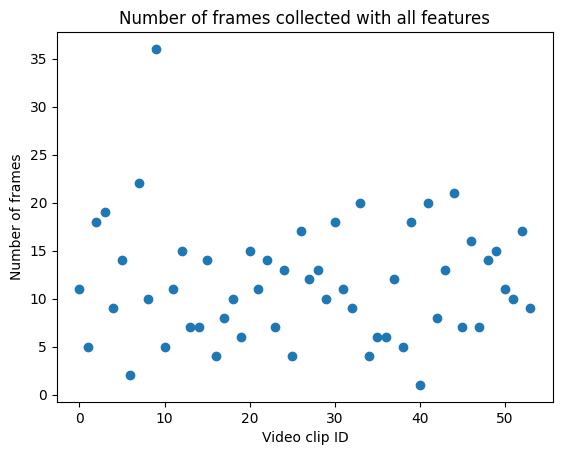

In [ ]:
plt.scatter(range(len(lengths)), lengths)
plt.xlabel("Video clip ID")
plt.ylabel("Number of frames")
plt.title("Number of frames collected with all features")
plt.show()

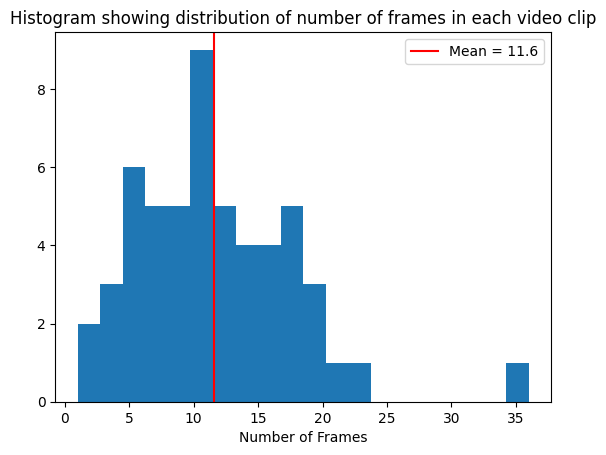

In [ ]:
plt.hist(lengths, bins=20)
plt.axvline(np.mean(lengths), c='red', label=f'Mean = {round(np.mean(lengths), 1)}')
plt.legend()
plt.title("Histogram showing distribution of number of frames in each video clip")
plt.xlabel("Number of Frames")
plt.show()

## Models

### Preprocessing

In [ ]:
def add_padding(video):
  length = len(video)
  new_df = pd.DataFrame(columns = list(df.columns))
  while length < num_frames:
    # number of columns
    padding = [0] * 15 + [video['video id'].values[0]] + [video['result'].values[0]]
    temp_df = pd.DataFrame([padding], columns = list(df.columns))
    new_df = pd.concat([new_df, temp_df], ignore_index=True)
    length += 1

  video = pd.concat([new_df, video], ignore_index=True)
  while length > num_frames:
    video = video.drop(video.index[0])
    length=len(video)

  return video

In [ ]:
## create dataframe with 15 frames
num_frames=15
final_df = pd.DataFrame(columns=list(df.columns))
for id in unique_videos_id:
  final_df = pd.concat([final_df, add_padding(df[df['video id'] == id])], ignore_index=True)

In [ ]:
final_df.head()

,Player Distance,P1 f-left,P1 f-right,P1 b-left,P1 b-right,P2 f-left,P2 f-right,P2 b-left,P2 b-right,P1 ball,P2 ball,B f-left,B f-right,B b-left,B b-right,video id,result
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,168.002976,715.629094,768.016276,473.81431,549.749034,654.369926,872.900911,377.524834,690.131147,1715.270241,1685.634895,1039.931248,1314.974144,2014.480578,2169.292972,0,0


In [ ]:
y = final_df['result']
X = final_df.drop(columns=['video id','result']).astype(float)
#X = final_df[['Player Distance', 'P1 ball', 'P2 ball']].astype(float)
length_data = 54
num_features = X.shape[1]

In [ ]:
X_reshape = X.values.reshape(length_data, num_frames, num_features)
y_reshape = y.values.reshape(length_data, num_frames)
y_reshape = tf.keras.utils.to_categorical(y_reshape[:, 0], num_classes=3)
X_train, X_test, y_train, y_test = train_test_split(X_reshape, y_reshape, test_size=0.1, stratify=y_reshape)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, stratify=y_train)

### Analysis of Preprocessed data

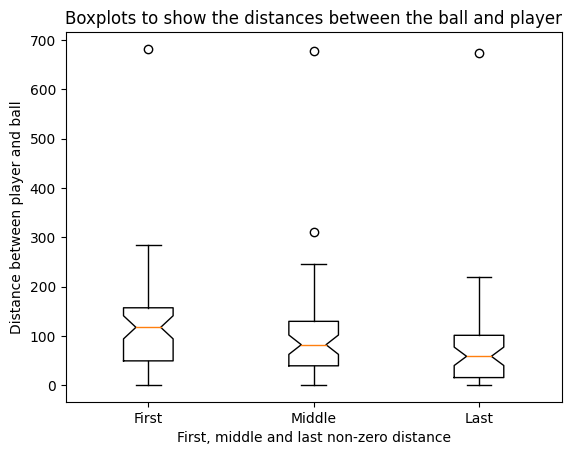

In [ ]:
# 0 for player distances, 9 for P1 Ball distance, 10 for P2 Ball distance

X_reshape_first = X_reshape[:, :, 0]
firsts, mids, lasts = [],[],[]

for col in X_reshape_first:
  non_zeros = col[col != 0]
  if len(non_zeros) <= 0:
    continue
  firsts.append(non_zeros[0])
  mids.append(non_zeros[len(non_zeros)//2])
  lasts.append(non_zeros[-1])

plt.boxplot((firsts, mids, lasts), [1, 2, 3])
plt.xticks([1, 2, 3], ['First', 'Middle', 'Last'])
plt.ylabel("Distance between player and ball")
plt.xlabel("First, middle and last non-zero distance")
plt.title("Boxplots to show the distances between the ball and player")

plt.show()

### Models

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score

def plot_conf_mat(y_pred, y_test):

  # Confusion matrix
  cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

  # Plotting confusion matrix
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cbar=False)
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.title('Confusion Matrix')
  plt.show()

def get_accuracy(predicted, true):
  return accuracy_score(np.argmax(true, axis=1), np.argmax(predicted, axis=1))

def get_precision(predicted, true):
  return precision_score(np.argmax(true, axis=1), np.argmax(predicted, axis=1), average='weighted')

def show_metrics(model, X_test, y_test):
  y_pred = model.model.predict(X_test)
  plot_conf_mat(y_pred, y_test)
  print(f"Accuracy: {get_accuracy(y_pred, y_test)}")
  print(f"Precision: {get_precision(y_pred, y_test)}")

In [ ]:
def plot_history(history, label):
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label='val_accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title("Showing the training and validation accuracy of the " + label)
  plt.legend()
  plt.show()


In [ ]:
class LSTM:

  def __init__(self,num_frame, num_features=15):

    # Define the LSTM model
    self.model = tf.keras.Sequential([
        tf.keras.layers.LSTM(32, input_shape=(num_frame, num_features)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')  # Three output units with softmax activation
    ])
    # Compile the model
    self.model.compile(optimizer='adam',
                  loss='categorical_crossentropy',  # Use categorical crossentropy for multi-class classification
                  metrics=['accuracy'])

  def train(self, X_train, X_val, y_train, y_val, epochs=1000, batch_size=40):
    return self.model.fit(X_train,y_train,batch_size=batch_size,epochs=epochs, validation_data=(X_test, y_test), verbose=0)


In [ ]:
lstm_model = LSTM(num_frames, num_features=num_features)
lstm_history = lstm_model.train(X_train, X_val, y_train, y_val)

In [ ]:
lstm_model.model.save_weights("inteference.h5")

In [ ]:
len(X_train)

40

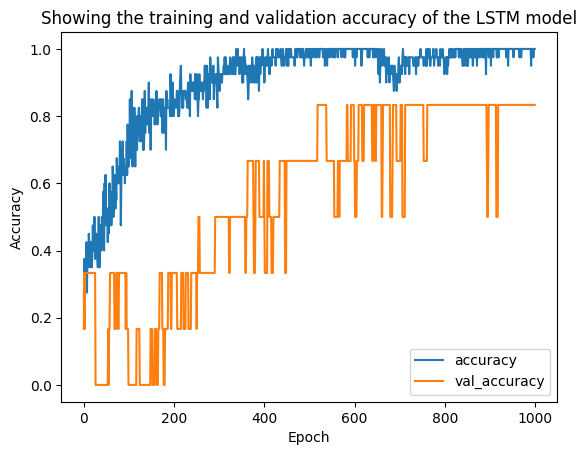

In [ ]:
plot_history(lstm_history, "LSTM model")

1/1 [==============================] - 0s 428ms/step


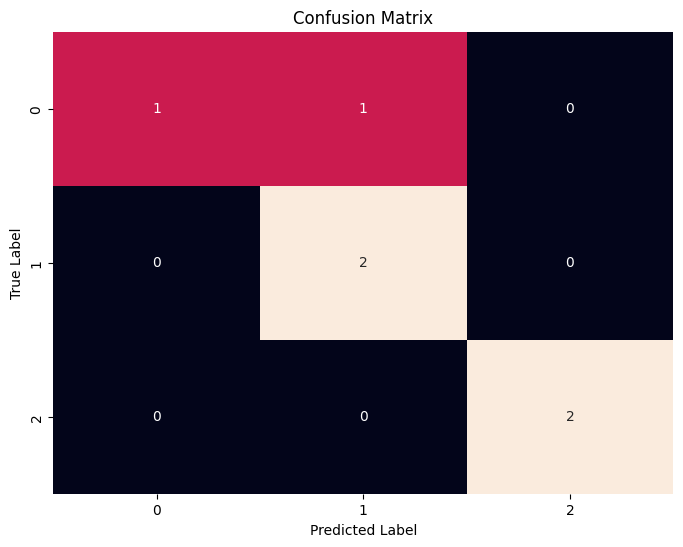

Accuracy: 0.8333333333333334
Precision: 0.8888888888888888


In [ ]:
show_metrics(lstm_model, X_test, y_test)

In [ ]:
class GRU:

  def __init__(self,num_frame, num_features=15):

    # Define the LSTM model
    self.model = tf.keras.Sequential([
        tf.keras.layers.GRU(16, input_shape=(num_frames, num_features)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        #tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')  # Three output units with softmax activation
    ])
    # Compile the model
    self.model.compile(optimizer='adam',
                  loss='categorical_crossentropy',  # Use categorical crossentropy for multi-class classification
                  metrics=['accuracy'])

  def train(self, X_train, X_val, y_train, y_val, epochs=1000, batch_size=32):
    return self.model.fit(X_train,y_train,batch_size=batch_size,epochs=epochs, validation_data=(X_val, y_val), verbose=0)


In [ ]:
gru_model = GRU(num_frames, num_features=num_features)
gru_history = gru_model.train(X_train, X_val, y_train, y_val)

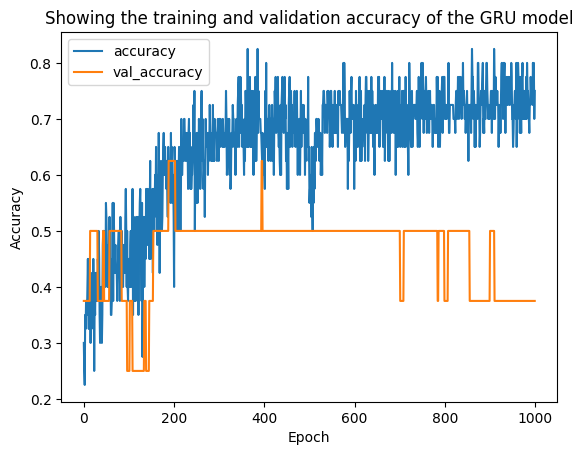

In [ ]:
plot_history(gru_history, "GRU model")

1/1 [==============================] - 0s 367ms/step


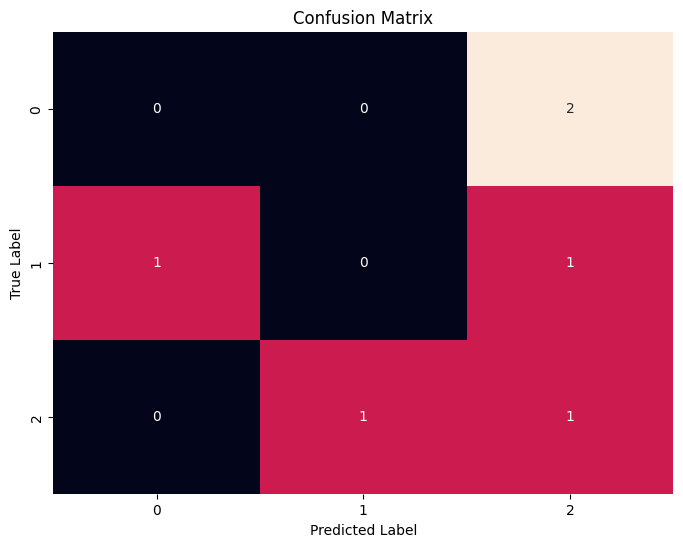

Accuracy: 0.16666666666666666
Precision: 0.08333333333333333


In [ ]:
show_metrics(gru_model, X_test, y_test)

In [ ]:
class CNN:

  def __init__(self,num_frame, num_features=15):

    # Define the LSTM model
    self.model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(num_frames, num_features, 1)),
        tf.keras.layers.AveragePooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        #tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')  # Three output units with softmax activation
    ])
    # Compile the model
    self.model.compile(optimizer='adam',
                  loss='categorical_crossentropy',  # Use categorical crossentropy for multi-class classification
                  metrics=['accuracy'])

  def train(self, X_train, X_val, y_train, y_val, epochs=1000, batch_size=32):
    return self.model.fit(X_train,y_train,batch_size=batch_size,epochs=epochs, validation_data=(X_val, y_val), verbose = 0)

In [ ]:
cnn_model = CNN(num_frames, num_features=num_features)
cnn_history = cnn_model.train(X_train, X_val, y_train, y_val)

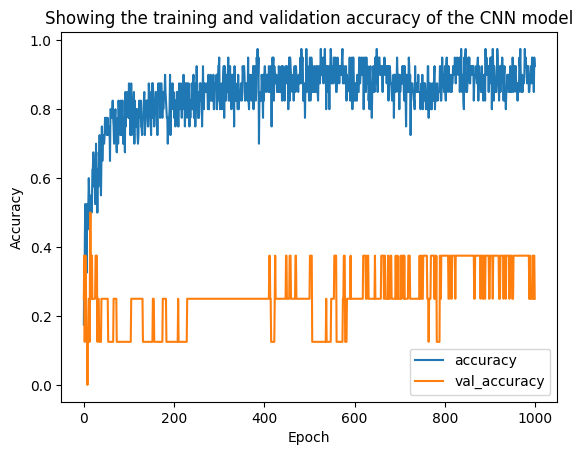

In [ ]:
plot_history(cnn_history, "CNN model")

1/1 [==============================] - 0s 70ms/step


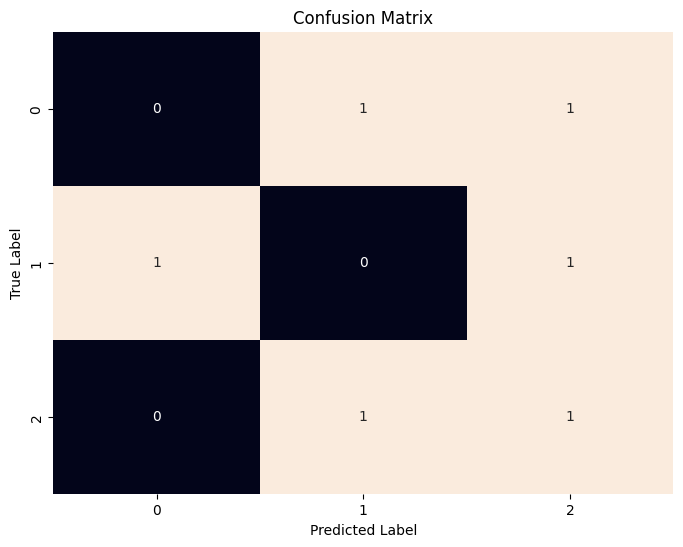

Accuracy: 0.16666666666666666
Precision: 0.1111111111111111


In [ ]:
show_metrics(cnn_model, X_test, y_test)

In [ ]:
5/9

0.5555555555555556

45